In [10]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

sys.path.append('../')

from src.emotion.analysis.data_preprocessing import (
    DataPreprocessor,
    LinearInterpolator,
    RollingAverageSmoother,
)

from src.emotion.analysis.feature_generator import FeatureGenerator, VelocityGenerator

%matplotlib inline
pd.set_option('display.max_columns', None)

In [11]:
folder = '/home/moritz/Workspace/masterthesis/data/identities/'
df = pd.read_csv(folder + 'team_20/2023-01-10/team_20_2023-01-10.csv')

In [12]:
feature_pipeline = [VelocityGenerator()]

feature_generator = FeatureGenerator(feature_pipeline)
feature_df = feature_generator.generate_features(df)

feature_df.head()

,Frame,ClassID,Confidence,x_center,y_center,Angry,Disgust,Happy,Sad,Surprise,Fear,Neutral,GazeDetections,Brightness,Velocity
0,0,person_id1,0.888322,963.261841,609.813171,0.006095,0.025079,0.089205,0.181192,0.000575,0.005860,0.691994,['person_id2'],139.656602,0.000000
1,0,person_id4,0.829193,776.653320,232.195343,0.039845,0.044471,0.192252,0.035983,0.034824,0.106690,0.545934,['person_id1'],139.656602,0.000000
2,0,person_id2,0.716269,262.923309,278.470093,0.000042,0.000052,0.986540,0.000961,0.006420,0.000264,0.005722,[],139.656602,0.000000
3,5,person_id1,0.888996,975.549072,616.918701,0.003787,0.013471,0.651937,0.103395,0.000332,0.001300,0.225778,['person_id2'],140.160465,14.193823
4,5,person_id4,0.801439,766.165710,233.864716,0.109647,0.280549,0.016583,0.430486,0.025592,0.058128,0.079016,['person_id1'],140.160465,10.619641


In [13]:

# TODO: Only compute derivatives, when consecutive frames are less than 10 frame apart!
preprocessing_pipeline = [
        LinearInterpolator(),
        RollingAverageSmoother(window_size=25, cols=["Velocity"]),
    ]

preprocessor = DataPreprocessor(preprocessing_pipeline)
pre_df = preprocessor.preprocess_data(feature_df)

pre_df.head()

,Frame,Confidence,x_center,y_center,Angry,Disgust,Happy,Sad,Surprise,Fear,Neutral,Brightness,Velocity,ClassID
0,0,0.888322,963.261841,609.813171,0.006095,0.025079,0.089205,0.181192,0.000575,0.005860,0.691994,139.656602,15.463864,person_id1
1,5,0.888996,975.549072,616.918701,0.003787,0.013471,0.651937,0.103395,0.000332,0.001300,0.225778,140.160465,14.393450,person_id1
2,10,0.858353,1011.880005,632.941284,0.018559,0.016245,0.645934,0.023734,0.001950,0.002996,0.290582,140.381493,13.439831,person_id1
3,15,0.839160,1029.355957,625.232300,0.026480,0.001816,0.371151,0.221569,0.002748,0.005833,0.370404,141.136083,12.692243,person_id1
4,20,0.844532,1031.143921,624.424683,0.003829,0.000801,0.016477,0.147213,0.006910,0.003163,0.821607,141.495661,12.106744,person_id1


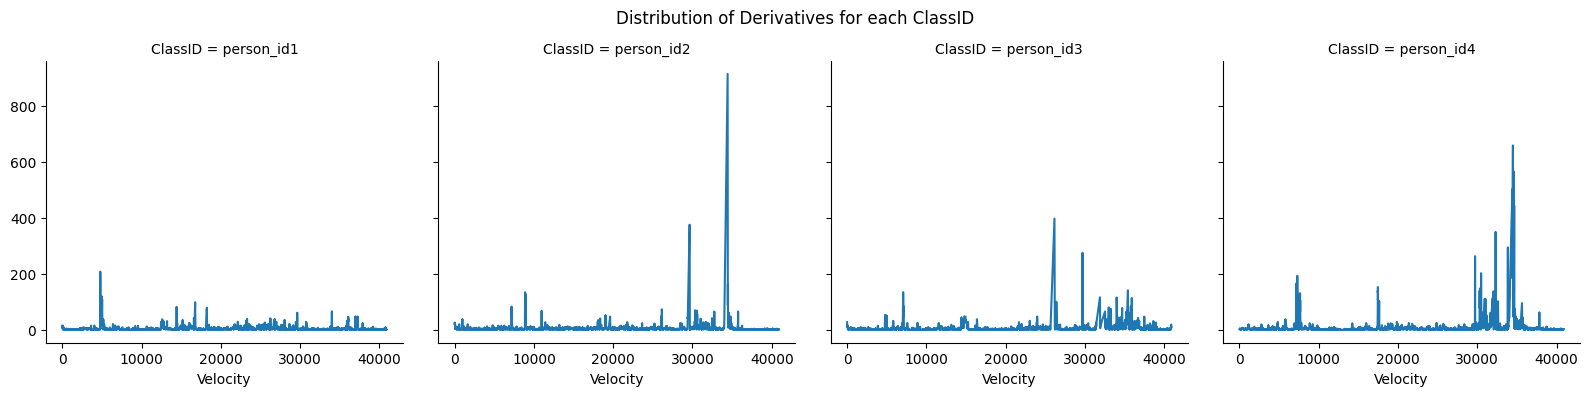

In [14]:
# Create the FacetGrid
g = sns.FacetGrid(data=pre_df, col='ClassID', col_wrap=4, height=4, sharey=True)
g.map(plt.plot, 'Velocity')

# Set the plot properties
plt.subplots_adjust(wspace=0.1, top=0.85)
g.fig.suptitle('Distribution of Derivatives for each ClassID')

# Show the plot
plt.show()

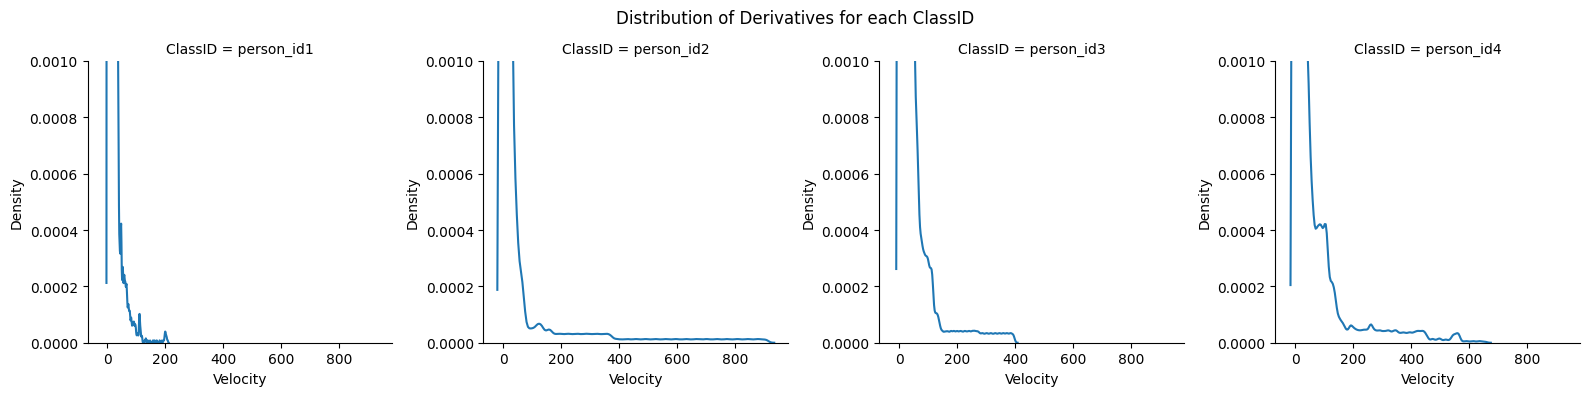

In [15]:
# TODO: Standard Normalization seems appropriate, but should we use the whole cohort as reference?
# Create the FacetGrid
g = sns.FacetGrid(data=pre_df, col='ClassID', col_wrap=4, height=4, sharey=False, sharex=True, ylim=(0, 0.001))
g.map(sns.kdeplot, 'Velocity')

plt.subplots_adjust(wspace=0.3, top=0.85)
g.fig.suptitle('Distribution of Derivatives for each ClassID')

plt.show()

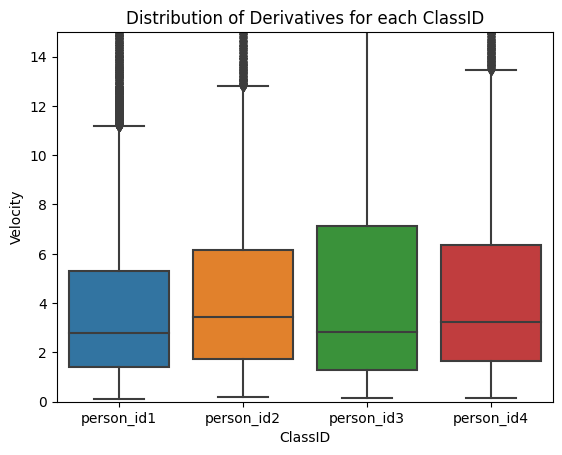

In [16]:
# Boxplot
sns.boxplot(data=pre_df, x='ClassID', y='Velocity')

plt.title('Distribution of Derivatives for each ClassID')
# Note, that we are cutting off some outliers here
plt.ylim(0, 15)

plt.show()

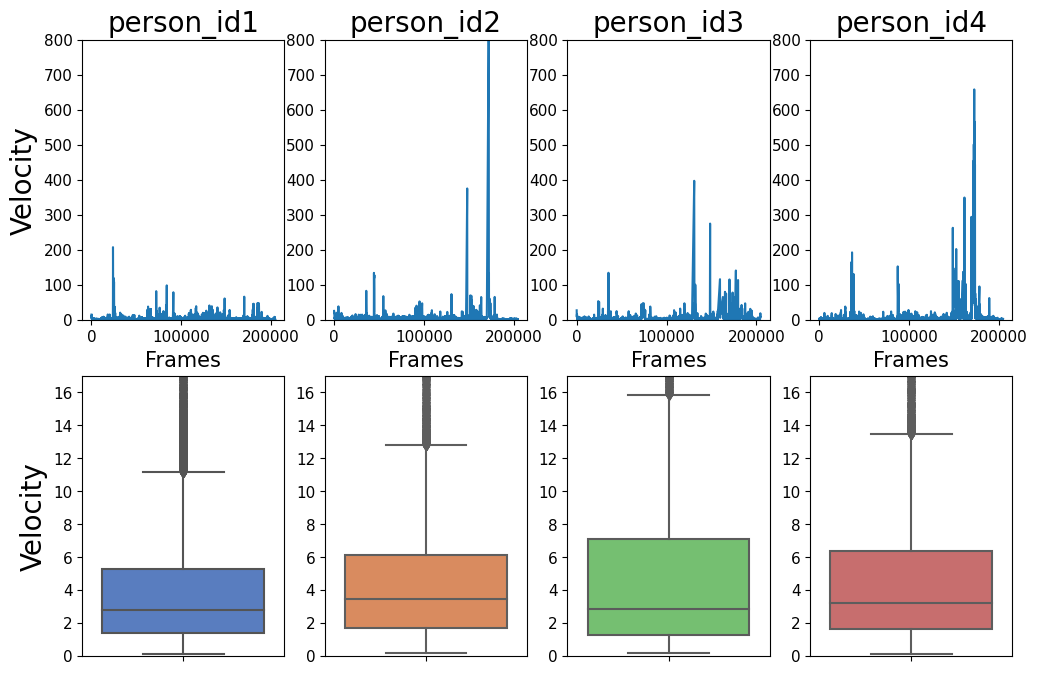

In [17]:
# Create a custom color palette
palette = sns.color_palette("muted", n_colors=4)

# Create a 4x1 grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12, 8))

# Plot the velocity time series in the upper row
colors = ['red', 'green', 'blue', 'orange']
for i, class_id in enumerate(pre_df['ClassID'].unique()):
    ax = axs[0, i]
    sns.lineplot(data=pre_df[pre_df['ClassID'] == class_id], x='Frame', y='Velocity', ax=ax)
    ax.set_title(f'{class_id}', fontsize=20)
    ax.set_ylim(0, 800)
    ax.set_xlabel('Frames', fontsize=15)
    ax.set_ylabel('')
    ax.tick_params(axis='both', which='major', labelsize=11)
    if i == 0:
        ax.set_ylabel('Velocity', fontsize=20)

# Plot the boxplots in the lower row
for i, class_id in enumerate(pre_df['ClassID'].unique()):
    ax = axs[1, i]
    sns.boxplot(data=pre_df[pre_df['ClassID'] == class_id], y='Velocity', palette=palette[i:i+1], ax=ax)
    ax.set_ylim(0, 17)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='both', which='major', labelsize=11)
    if i == 0:
        ax.set_ylabel('Velocity', fontsize=20)

# Adjust the layout and spacing
#plt.tight_layout()
path = "/home/moritz/Dropbox (Personal)/Dropbox/Apps/Overleaf/tum-thesis-latex/data/05_results"
image = path + "/velocity.pdf"
plt.savefig(image, bbox_inches='tight', dpi=300)



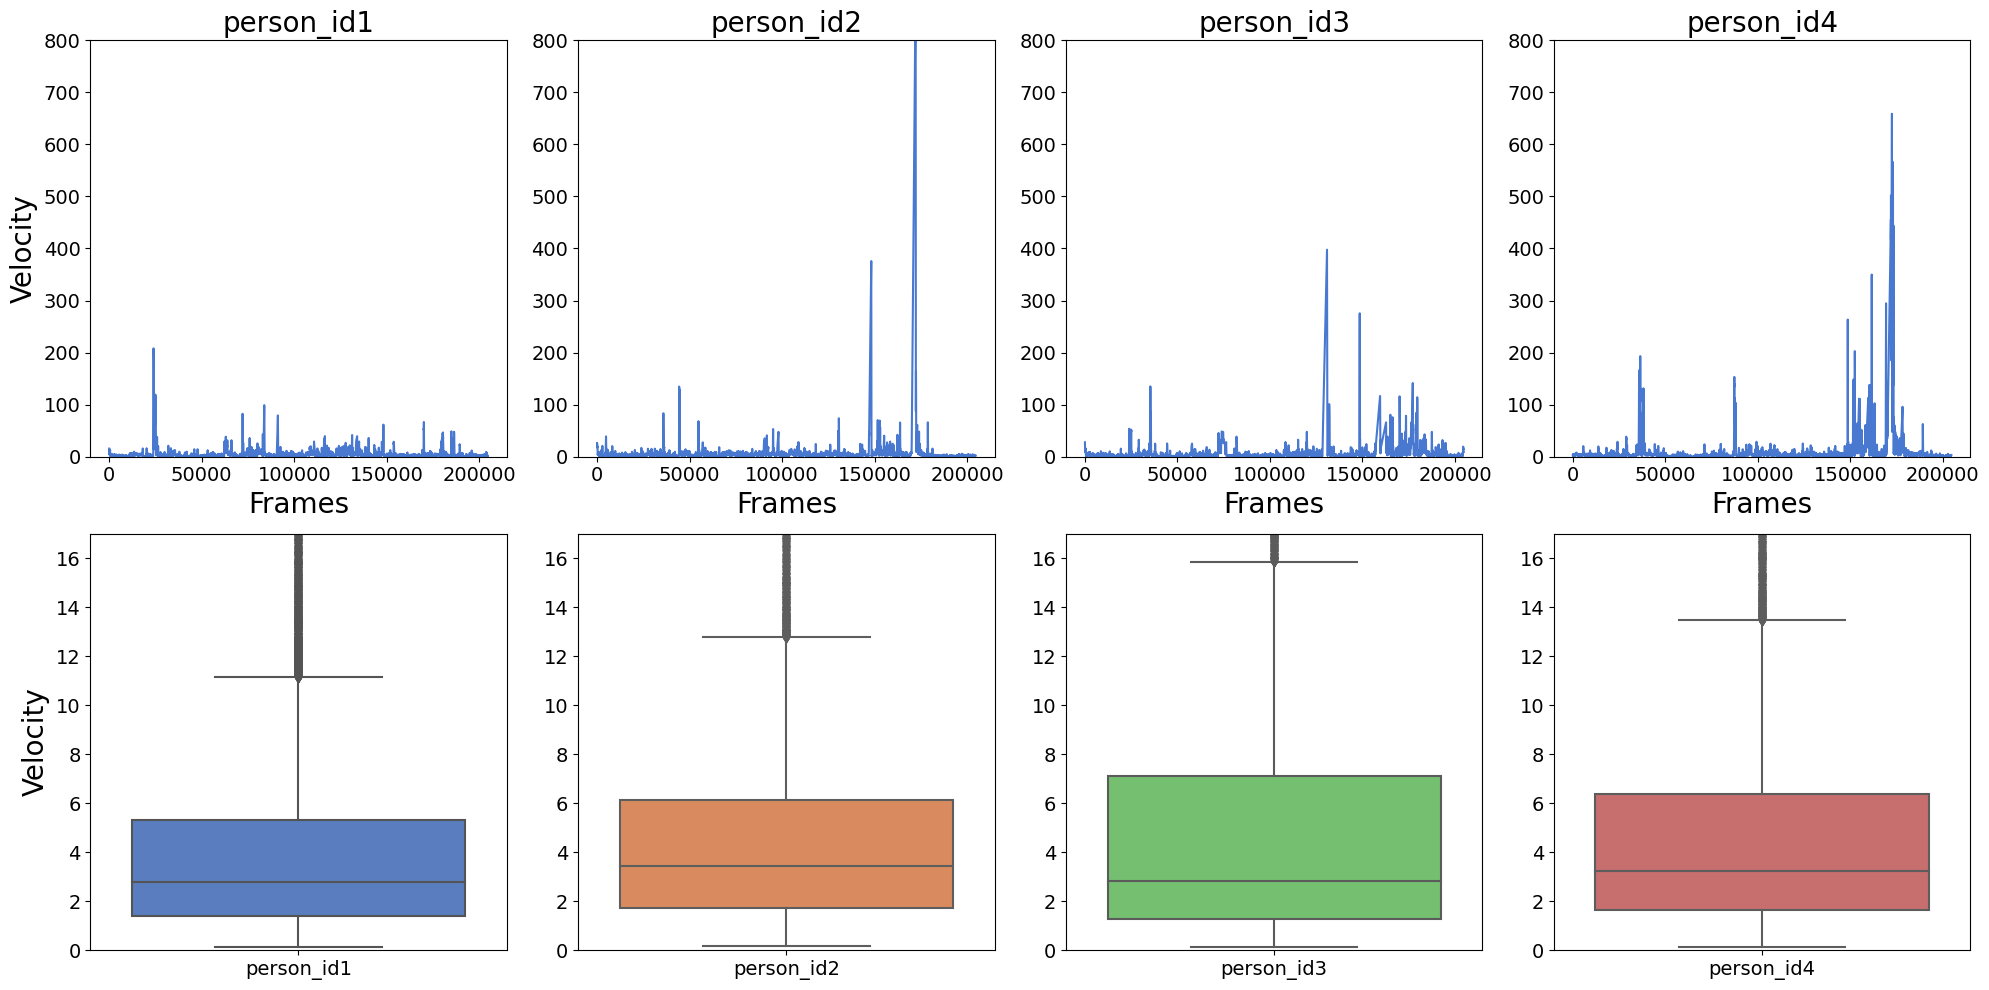

In [18]:
grouped = pre_df.groupby("ClassID")
class_ids = pre_df['ClassID'].unique()

fig = plt.figure(figsize=(20, 10), tight_layout=True)

gs = gridspec.GridSpec(2, len(class_ids), height_ratios=[1, 1])

# Create a custom color palette
palette = sns.color_palette("muted", n_colors=len(class_ids))

# Set font sizes
title_font_size = 20
label_font_size = 20
tick_font_size = 14

for i, cid in enumerate(class_ids):
    group = grouped.get_group(cid)

    # Velocity time series plot (upper half)
    ax1 = plt.subplot(gs[0, i])
    sns.lineplot(data=group, x='Frame', y='Velocity', ax=ax1, color=palette[0])

    ax1.set_title(f"{cid}", fontsize=title_font_size)
    ax1.set_xlabel("Frames", fontsize=label_font_size)
    ax1.tick_params(axis='both', which='major', labelsize=tick_font_size)
    ax1.set_ylabel("", fontsize=label_font_size)
    if i == 0:
        ax1.set_ylabel("Velocity", fontsize=label_font_size)
    ax1.set_ylim(0, 800)

    # Velocity boxplot (lower half)
    ax2 = plt.subplot(gs[1, i])
    sns.boxplot(data=group, x='ClassID', y='Velocity', palette=palette[i:i+1], ax=ax2)

    ax2.set_xlabel("", fontsize=label_font_size)
    ax2.tick_params(axis='both', which='major', labelsize=tick_font_size)
    ax2.set_ylabel("", fontsize=label_font_size)
    if i == 0:
        ax2.set_ylabel("Velocity", fontsize=label_font_size)
    ax2.set_ylim(0, 17)